# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.447002,False,1.174281
1,-1.050126,True,3.629040
2,-1.501111,True,3.988870
3,-0.039659,True,5.017016
4,2.017563,True,6.804364
...,...,...,...
995,-1.314308,False,1.977641
996,-0.179341,True,4.110115
997,0.458268,True,3.277740
998,-0.868252,False,-0.860965


<Axes: xlabel='v0'>

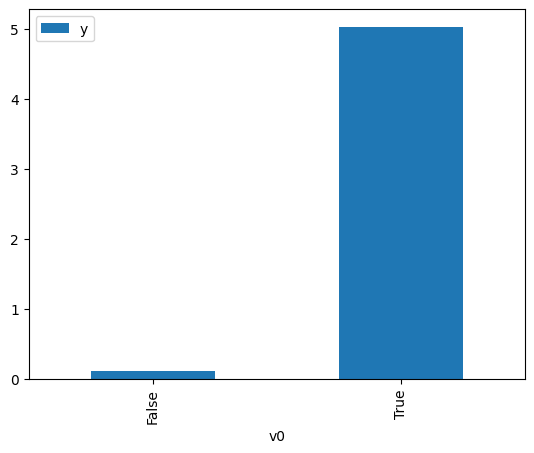

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

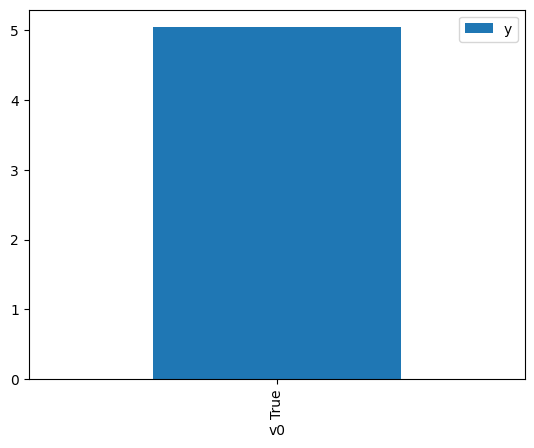

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.247441,False,0.763612,0.485976,2.057715
1,-0.579738,False,-0.883542,0.540495,1.850155
2,1.670246,False,1.425550,0.393683,2.540114
3,0.744647,False,0.123407,0.453282,2.206130
4,1.168095,False,0.720391,0.425742,2.348839
...,...,...,...,...,...
995,1.160384,False,0.889498,0.426240,2.346095
996,0.832942,False,-0.186731,0.447510,2.234585
997,0.732046,False,-0.132362,0.454107,2.202123
998,0.944275,False,0.483526,0.440253,2.271423


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.913779,True,6.252991,0.437688,2.284735
1,-0.301392,True,3.629496,0.477808,2.092893
2,-0.626810,True,4.983732,0.456419,2.190969
3,-0.159469,True,5.201869,0.487166,2.052689
4,0.579362,True,4.611252,0.535880,1.866089
...,...,...,...,...,...
995,1.713288,True,5.850647,0.609027,1.641964
996,-0.884873,True,2.052748,0.439567,2.274965
997,0.460341,True,6.133796,0.528054,1.893744
998,-0.225383,True,6.102531,0.482818,2.071174


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              6961.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):                        0.00
Time:                        07:27:41   Log-Likelihood:                         -1402.5
No. Observations:                1000   AIC:                                      2809.
Df Residuals:                     998   BIC:                                      2819.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3757      0.032     11.805      0.000       0.313       0.438
x2             4.9272      0.045    108.762      0.000       4.838       5.016
==============================================================================
Omnibus:                        2.486   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                2.497
Skew:                           0.056   Prob(JB):                        0.287
Kurtosis:                       3.218   Cond. No.                         1.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""